Several functions in TPOT2 allow for a scaling parameter over the course of either the generations or over the cross validation folds (or when using the evolutionary algorithm on it's own, the discrete evaluation steps).

These parameters will take in a list of two values, a starting and ending value. These will be interpolated with a nondecreasing/nonincreasing function. specifically, it uses a beta distribution with alpha set to one an a user submitted beta function.

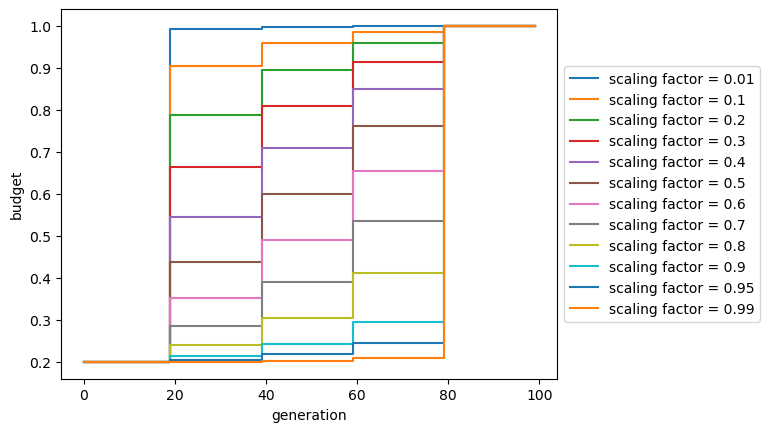

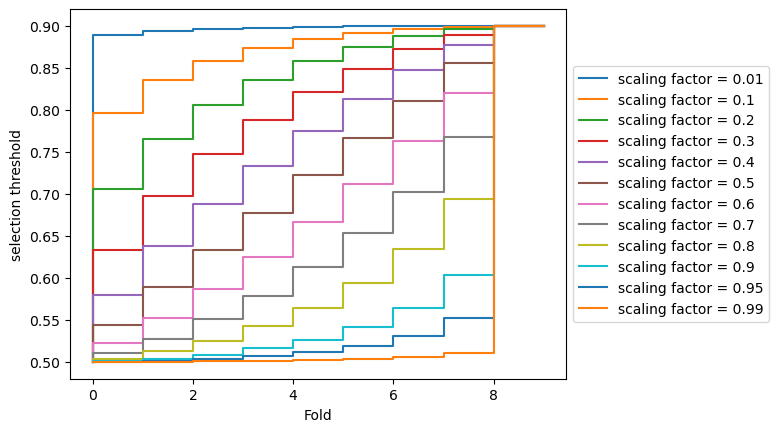

In [2]:
import tpot2
import matplotlib.pyplot as plt
import scipy
import numpy as np
import math
start = .2
end = 1
ngenerations = 100

#Population and budget use stepwise
ax = plt.subplot(111)
for scaling_factor in [0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.99]:
    interpolated_values = tpot2.beta_interpolation(start=start, end=end, scale=scaling_factor, n=ngenerations, n_steps=5)
    plt.step(list(range(len(interpolated_values))), interpolated_values, label=f"scaling factor = {scaling_factor}")
plt.xlabel("generation")
plt.ylabel("budget")
plt.legend()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


#CV early stopping thresholds
ax = plt.subplot(111)
for scaling_factor in [0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.99]:
    interpolated_values = tpot2.beta_interpolation(start=.5, end=.9, scale=scaling_factor, n=10)
    plt.step(list(range(len(interpolated_values))), interpolated_values, label=f"scaling factor = {scaling_factor}")
plt.xlabel("Fold")
plt.ylabel("selection threshold")
plt.legend()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Example 1:

Population size ranges from 200 to 50, and budget ranges from .3 to 1.

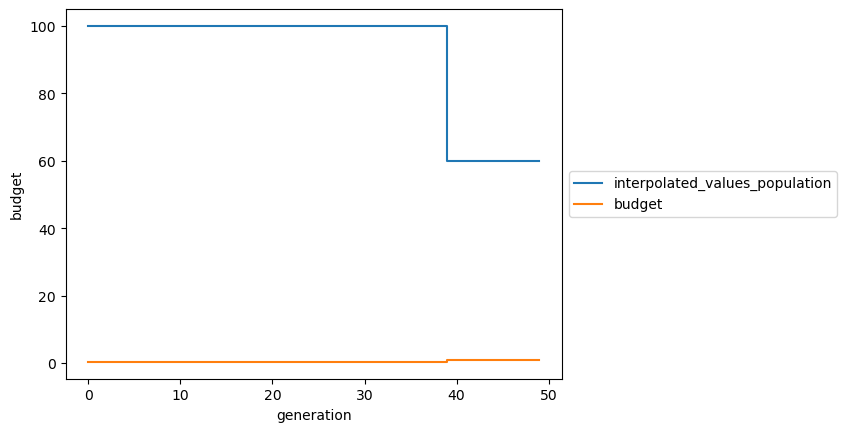

In [3]:
import matplotlib.pyplot as plt
import tpot2

population_size=60
initial_population_size=100
population_scaling = .5
generations_until_end_population = 50

budget_range = [.3,1]
generations_until_end_budget=50

#Population and budget use stepwise
ax = plt.subplot(111)

interpolated_values_population = tpot2.beta_interpolation(start=initial_population_size, end=population_size, n=50, n_steps=5)
interpolated_values_budget = tpot2.beta_interpolation(start=budget_range[0], end=budget_range[1], n=50, n_steps=5)
plt.step(list(range(len(interpolated_values_population))), interpolated_values_population, label=f"interpolated_values_population")
plt.step(list(range(len(interpolated_values_budget))), interpolated_values_budget, label=f"budget")
plt.xlabel("generation")
plt.ylabel("budget")
plt.legend()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


In [3]:
# A Graph pipeline starting with at least one selector as a leaf, potentially followed by a series
# of stacking classifiers or transformers, and ending with a classifier. The graph will have at most 15 nodes and a max depth of 6.

import tpot2
import sklearn
import sklearn.datasets
import numpy as np
import time
import tpot2
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
import sklearn

X, y = sklearn.datasets.load_iris(return_X_y=True)

est = tpot2.TPOTEstimator(  
                            generations=5,
                            scorers=['roc_auc_ovr'],
                            scorers_weights=[1],
                            classification=True,
                            root_config_dict="classifiers",
                            inner_config_dict= ["transformers"],
                            leaf_config_dict="selectors",
                            n_jobs=32,
                            cv=2,
                            max_eval_time_seconds=30,

                            population_size=population_size,
                            initial_population_size=initial_population_size,
                            population_scaling = population_scaling,
                            generations_until_end_population = generations_until_end_population,
                            
                            budget_range = budget_range,
                            generations_until_end_budget=generations_until_end_budget,
                            verbose=0)


start = time.time()
est.fit(X, y)
print(f"total time: {time.time()-start}")

total time: 195.15858101844788


In [4]:
est = tpot2.TPOTEstimator(  
                            generations=5,
                            scorers=['roc_auc_ovr'],
                            scorers_weights=[1],
                            classification=True,
                            root_config_dict="classifiers",
                            inner_config_dict= ["transformers"],
                            leaf_config_dict="selectors",
                            n_jobs=32,
                            cv=2,
                            max_eval_time_seconds=30,

                            population_size=60,
                            initial_population_size=100,
                            population_scaling = .5,
                            generations_until_end_population = 4,
                            
                            # budget_range = [.3,1],
                            # generations_until_end_budget=4,

                            threshold_evaluation_early_stop = [30,50],
                            threshold_evaluation_scaling = .2,
                            selection_evaluation_early_stop = [.5,1],
                            selection_evaluation_scaling = .2,

                            verbose=0)


start = time.time()
est.fit(X, y)
print(f"total time: {time.time()-start}")

total time: 121.15116667747498


In [5]:
est = tpot2.TPOTEstimator(  
                            generations=5,
                            scorers=['roc_auc_ovr'],
                            scorers_weights=[1],
                            classification=True,
                            root_config_dict="classifiers",
                            inner_config_dict= ["transformers"],
                            leaf_config_dict="selectors",
                            n_jobs=32,
                            cv=2,
                            max_eval_time_seconds=30,

                            population_size=60,
                            initial_population_size=100,
                            population_scaling = .5,
                            generations_until_end_population = 4,
                            
                            # budget_range = [.3,1],
                            # generations_until_end_budget=4,

                            # threshold_evaluation_early_stop = [30,50],
                            # threshold_evaluation_scaling = .2,
                            # selection_evaluation_early_stop = [.5,1],
                            # selection_evaluation_scaling = .2,

                            verbose=0)


start = time.time()
est.fit(X, y)
print(f"total time: {time.time()-start}")

total time: 121.64871382713318


In [6]:
est = tpot2.TPOTEstimator(  
                            generations=5,
                            scorers=['roc_auc_ovr'],
                            scorers_weights=[1],
                            classification=True,
                            root_config_dict="classifiers",
                            inner_config_dict= ["transformers"],
                            leaf_config_dict="selectors",
                            n_jobs=32,
                            cv=2,
                            max_eval_time_seconds=30,

                            population_size=60,
                            initial_population_size=100,
                            population_scaling = .5,
                            generations_until_end_population = 4,
                            
                            budget_range = [.3,1],
                            generations_until_end_budget=4,

                            # threshold_evaluation_early_stop = [30,50],
                            # threshold_evaluation_scaling = .2,
                            # selection_evaluation_early_stop = [.5,1],
                            # selection_evaluation_scaling = .2,

                            verbose=0)


start = time.time()
est.fit(X, y)
print(f"total time: {time.time()-start}")

total time: 82.53835797309875


In [7]:
est = tpot2.TPOTEstimator(  
                            generations=5,
                            scorers=['roc_auc_ovr'],
                            scorers_weights=[1],
                            classification=True,
                            root_config_dict="classifiers",
                            inner_config_dict= ["transformers"],
                            leaf_config_dict="selectors",
                            n_jobs=32,
                            cv=2,
                            max_eval_time_seconds=30,

                            population_size=60,
                            initial_population_size=100,
                            population_scaling = .5,
                            generations_until_end_population = 4,
                            
                            # budget_range = [.3,1],
                            # generations_until_end_budget=4,

                            # threshold_evaluation_early_stop = [30,50],
                            # threshold_evaluation_scaling = .2,
                            # selection_evaluation_early_stop = [.5,1],
                            # selection_evaluation_scaling = .2,

                            verbose=0)


start = time.time()
est.fit(X, y)
print(f"total time: {time.time()-start}")

total time: 132.47541308403015
